<h2 style="text-align: center; font-size: 24px;">
    <span style="color: #1E90FF;">✨Predicting finite-volume excited state energies using ChPT and the Lüscher formula✨</span> 
    <br>
    <span style="color: #87CEFA;">✨The code✨</span> 
</h2>

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import erf
from scipy.special import erfi
from scipy.optimize import root_scalar


In [5]:
# For the style of the plots
plt.rcParams.update({
    'font.size': 16,          # Base font size for text
    'axes.titlesize': 18,     # Title size for axes
    'axes.labelsize': 18,     # x/y label size
    'xtick.labelsize': 14,    # x-axis  label size
    'ytick.labelsize': 14,    # y-axis label size
    'legend.fontsize': 14,    # Legend font size
})

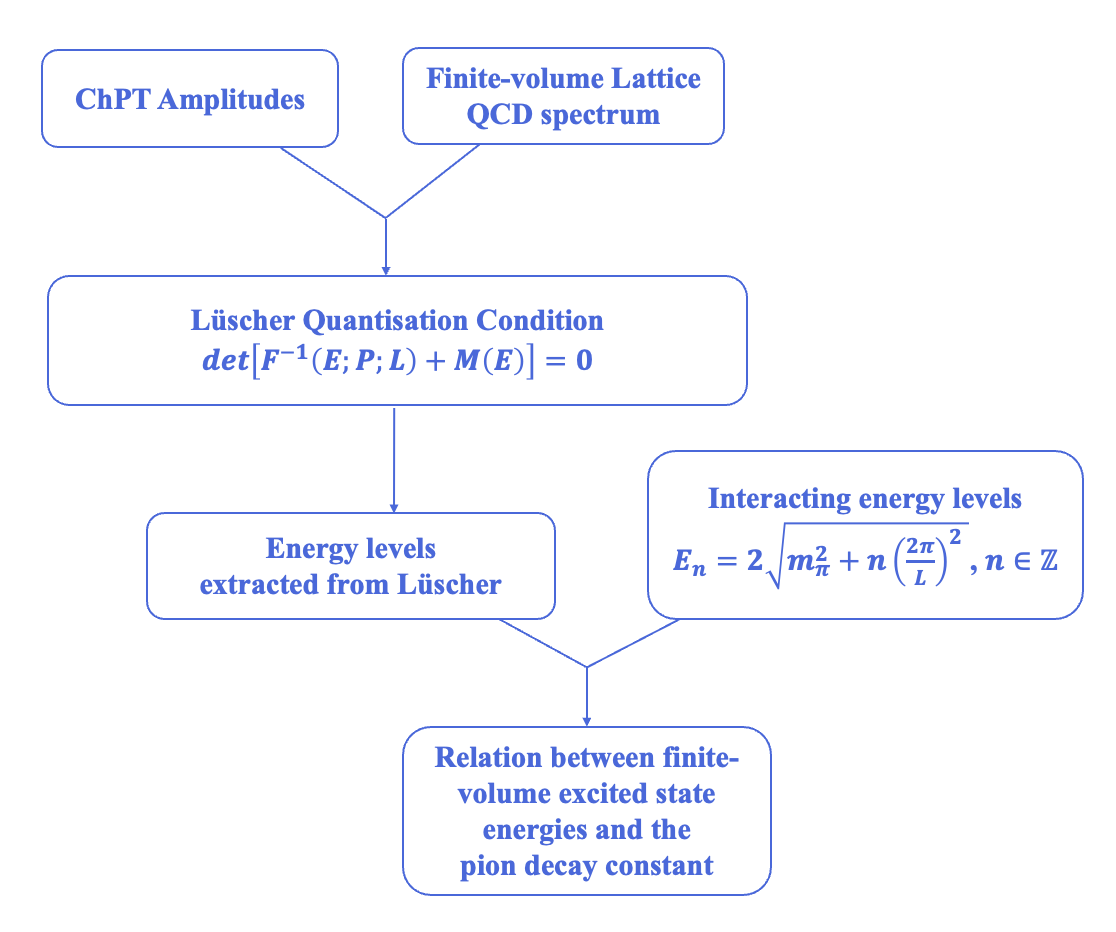

In [6]:
from IPython.display import Image
Image(filename='Method.png')


### Coding up the Lüscher Zeta Function
$$
Z_{0,0}(1; q^2) = \frac{1}{\sqrt{4\pi}} \lim_{\Lambda \to \infty} \left( \sum\limits^{|\mathbf{n}| < \Lambda}_{\mathbf{n}} \frac{1}{|\mathbf{n}|^2 - q^2} - 4\pi \Lambda \right)
$$

In [7]:
R4PI = np.sqrt(4.0*np.pi)  # norm. factor

def summand(qSQ=1.5, nvec_arr=np.array([[0,0,0]]), alphaKSS=1.0):
    rSQ_arr = (nvec_arr**2).sum(1)
    Ds = rSQ_arr-qSQ
    return np.exp(-alphaKSS*Ds)/Ds

def T1(qSQ=1.5, C1cut=3, alphaKSS=1.0):
    rng = range(-C1cut, C1cut+1)
    mesh = np.meshgrid(*([rng]*3))
    nvec_arr = np.vstack([y.flat for y in mesh]).T
    return np.sum(summand(qSQ, nvec_arr, alphaKSS))/R4PI

def T2(qSQ=1.5, alphaKSS=1.0):
    if qSQ >= 0:
        ttmp = 2.0*(np.pi**2)*np.sqrt(qSQ)\
                * erfi(np.sqrt(alphaKSS*qSQ))\
                - 2.0*np.exp(alphaKSS*qSQ)\
                * np.sqrt(np.pi**3)/np.sqrt(alphaKSS)
    else:
        ttmp = -2.0*(np.pi**2)*np.sqrt(-qSQ)\
                * erf(np.sqrt(-alphaKSS*qSQ))\
                - 2.0*np.exp(alphaKSS*qSQ)\
                * np.sqrt(np.pi**3)/np.sqrt(alphaKSS)
    return ttmp/R4PI

In [8]:
def zeta_function(qSQ=1.5, C1cut=3, alphaKSS=1.0):
    return T1(qSQ=qSQ, C1cut=C1cut, alphaKSS=alphaKSS)\
            + T2(qSQ=qSQ, alphaKSS=alphaKSS)

Text(0, 0.5, '$\\mathcal{Z}_{0,0}(1; {q}^2)$')

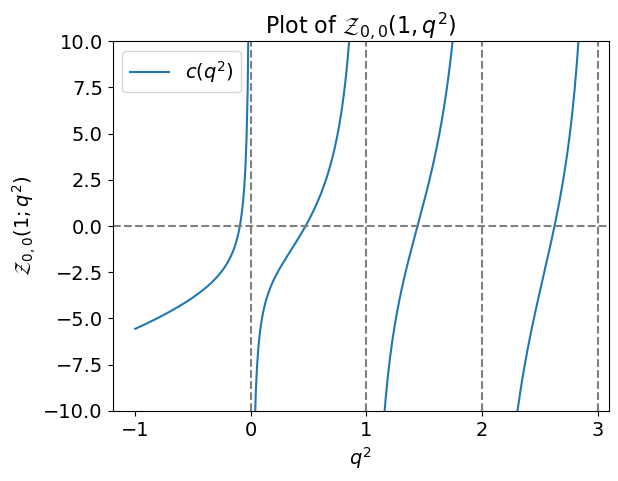

In [9]:
qSQ_set = np.linspace(-1.001, 3.001, 400)
zeta_set = []
for qSQ in qSQ_set:
    zeta_set.append(zeta_function(qSQ))
zeta_set = np.array(zeta_set)
zeta_set[np.abs(zeta_set) > 20] = np.nan
plt.plot(qSQ_set, zeta_set)
for qSQ_asymptote in range(4):
    plt.axvline(qSQ_asymptote, color='0.5', linestyle='--')
plt.legend(['$c(q^2)$'])
plt.xlabel('$q^2$')
plt.axhline(0, color='0.5', linestyle='--')
plt.ylim(-10, 10)
plt.title(r"Plot of $\mathcal{Z}_{0,0}(1, {q}^2)$", fontsize=16)
plt.xlabel(r"${q}^2$", fontsize=14)
plt.ylabel(r"$\mathcal{Z}_{0,0}(1; {q}^2)$", fontsize=14)


Text(0, 0.5, '$\\mathcal{Z}_{0,0}(1; {q}^2)$')

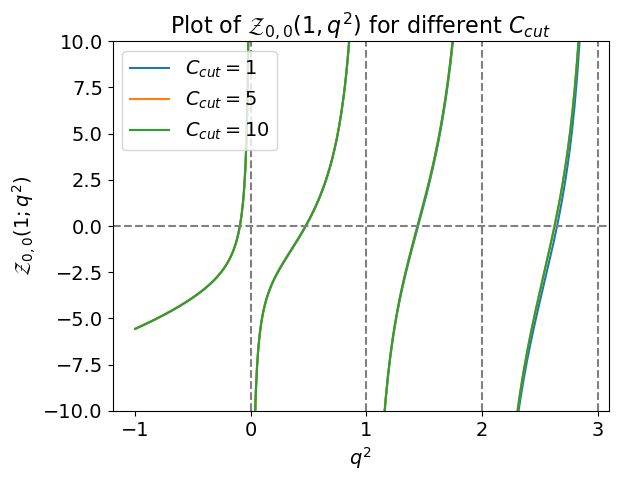

In [10]:
def plot_for_given_C1cut(ax, qSQset, C1cut):
    zeta_set = []
    for qSQ in qSQ_set:
        zeta_set.append(zeta_function(qSQ, C1cut=C1cut))
    zeta_set = np.array(zeta_set)
    zeta_set[np.abs(zeta_set) > 20] = np.nan
    ax.plot(qSQ_set, zeta_set)
ax = plt.gca()
for C1cut in [1, 5, 10]:
    plot_for_given_C1cut(ax, qSQ_set, C1cut)
for qSQ_asymptote in range(4):
    plt.axvline(qSQ_asymptote, color='0.5', linestyle='--')
plt.legend(['$C_{cut} = 1$', '$C_{cut} = 5$', '$C_{cut} = 10$'])
plt.xlabel('$q^2$')
plt.axhline(0, color='0.5', linestyle='--')
plt.ylim(-10, 10)
plt.title(r"Plot of $\mathcal{Z}_{0,0}(1, {q}^2)$ for different $C_{cut}$", fontsize=16)
plt.xlabel(r"${q}^2$", fontsize=14)
plt.ylabel(r"$\mathcal{Z}_{0,0}(1; {q}^2)$", fontsize=14)

No (significant) change for different cutoff parametres. :)

In [11]:
def amplitude(s, mSQ=1., fSQ=1.):  #ChPT amplitude (Leading Order)
    return -(s - 2.*mSQ)/fSQ

def rhs(qSQ, L=4., mSQ=1., fSQ=1.):
    pre = L*np.sqrt(np.pi)/2.
    pSQ = qSQ*2.*np.pi/L
    pSQ = qSQ * (2. * np.pi / L) ** 2
    s = 4.*(pSQ+mSQ)
    amp = amplitude(s, mSQ=mSQ, fSQ=fSQ)
    pcotd = 16.*np.pi*np.sqrt(s)/amp
    return pre*pcotd

def qc(qSQ, L=4., mSQ=1., fSQ=1., C1cut=3, alphaKSS=1.0):
    return rhs(qSQ, L=L, mSQ=mSQ, fSQ=fSQ)\
        - zeta_function(qSQ, C1cut=C1cut, alphaKSS=alphaKSS)

In [12]:
# use root scalar to find roots in qSQ from -.5 to 3.0 searching all intervals of width 0.1
from scipy.optimize import root_scalar
roots = []
for qSQ in np.arange(-0.5, 3.0, 0.01):
    try:
        res = root_scalar(qc, args=(4., 1., 1., 3, 1.0), bracket=[qSQ, qSQ+0.1])
        if res.converged:
            if np.abs(qc(res.root, 4., 1., 1., 3, 1.0)) < 1e-6:
                roots.append(res.root)
    except ValueError:
        pass
roots = np.array(roots)
print(roots)

[1.61545776e-03 1.03079103e+00 1.03079103e+00 1.03079103e+00
 1.03079103e+00 2.08836519e+00 2.08836519e+00 2.08836519e+00
 2.08836519e+00 2.08836519e+00 2.08836519e+00 2.08836519e+00
 2.08836519e+00 2.08836519e+00]


/var/folders/k6/tjn5pj4d7z9d29567xbyxl240000gn/T/ipykernel_19029/2900166119.py:10: RuntimeWarning: invalid value encountered in sqrt
  pcotd = 16.*np.pi*np.sqrt(s)/amp


$F_\pi=1$ We wil try different $F_\pi$ later

/var/folders/k6/tjn5pj4d7z9d29567xbyxl240000gn/T/ipykernel_19029/2900166119.py:10: RuntimeWarning: invalid value encountered in sqrt
  pcotd = 16.*np.pi*np.sqrt(s)/amp


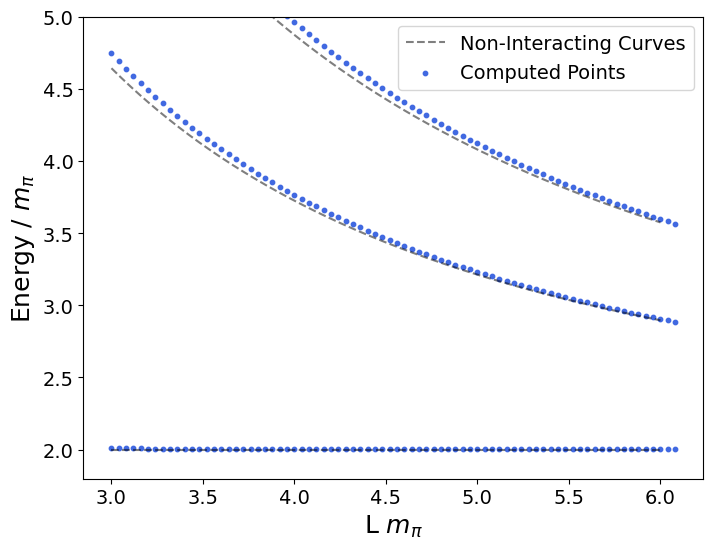

In [ ]:
L_values = np.arange(3.0, 6.1, 0.04)  # L from 3 to 6 in steps of 0.04
mSQ = 1.0
fSQ = 1.0

Lvalues = []
Evalues = []

for L in L_values:
    roots = []
    for qSQ in np.arange(-0.5, 3.0, 0.01):
        try:
            res = root_scalar(qc, args=(L, mSQ, fSQ, 3, 1.0), bracket=[qSQ, qSQ + 0.1])
            if res.converged:
                if np.abs(qc(res.root, L, mSQ, fSQ, 3, 1.0)) < 1e-6:
                    if not any(np.isclose(res.root, roots, atol=1e-9)):  # Remove duplicates
                        roots.append(res.root)
        except ValueError:
            pass

    roots = np.array(roots)
    
    E_vals = []
    for root in roots:
        pSQ = root * (2. * np.pi / L) ** 2
        s = 4. * (pSQ + mSQ)
        E_vals.append(np.sqrt(s))

    # Store results for each L
    for E in E_vals:
        Lvalues.append(L)
        Evalues.append(E)

pion_mass = np.sqrt(mSQ)
dimensionless_L = np.array(Lvalues) * pion_mass
dimensionless_E = np.array(Evalues) / pion_mass
energy_df = pd.DataFrame({"L": dimensionless_L, "Energy": dimensionless_E})
#print("\n *** Energy Levels for Different L Values *** ")
#print(energy_df)


plt.figure(figsize=(8, 6))
plt.scatter(dimensionless_L, dimensionless_E, color='royalblue', label="Computed Points", s=10)
L_set = np.linspace(3, 6, 400)
for nSQ in range(3):
    E_vals_nonint = 2 * np.sqrt(nSQ * (2. * np.pi / L_set) ** 2 + mSQ)
    plt.plot(L_set, E_vals_nonint, 'k--', alpha=0.5, label="Non-Interacting Curves" if nSQ == 0 else "")
plt.xlabel("L $m_\pi$")
plt.ylabel("Energy / $m_\pi$")
plt.ylim(1.8, 5)
plt.legend()


In the following cell we tune fSQ in order to see the dependence.

/var/folders/k6/tjn5pj4d7z9d29567xbyxl240000gn/T/ipykernel_19029/2900166119.py:10: RuntimeWarning: invalid value encountered in sqrt
  pcotd = 16.*np.pi*np.sqrt(s)/amp
/var/folders/k6/tjn5pj4d7z9d29567xbyxl240000gn/T/ipykernel_19029/2900166119.py:10: RuntimeWarning: invalid value encountered in sqrt
  pcotd = 16.*np.pi*np.sqrt(s)/amp
/var/folders/k6/tjn5pj4d7z9d29567xbyxl240000gn/T/ipykernel_19029/2900166119.py:10: RuntimeWarning: invalid value encountered in sqrt
  pcotd = 16.*np.pi*np.sqrt(s)/amp
/var/folders/k6/tjn5pj4d7z9d29567xbyxl240000gn/T/ipykernel_19029/2900166119.py:10: RuntimeWarning: invalid value encountered in sqrt
  pcotd = 16.*np.pi*np.sqrt(s)/amp
/var/folders/k6/tjn5pj4d7z9d29567xbyxl240000gn/T/ipykernel_19029/2900166119.py:10: RuntimeWarning: invalid value encountered in sqrt
  pcotd = 16.*np.pi*np.sqrt(s)/amp


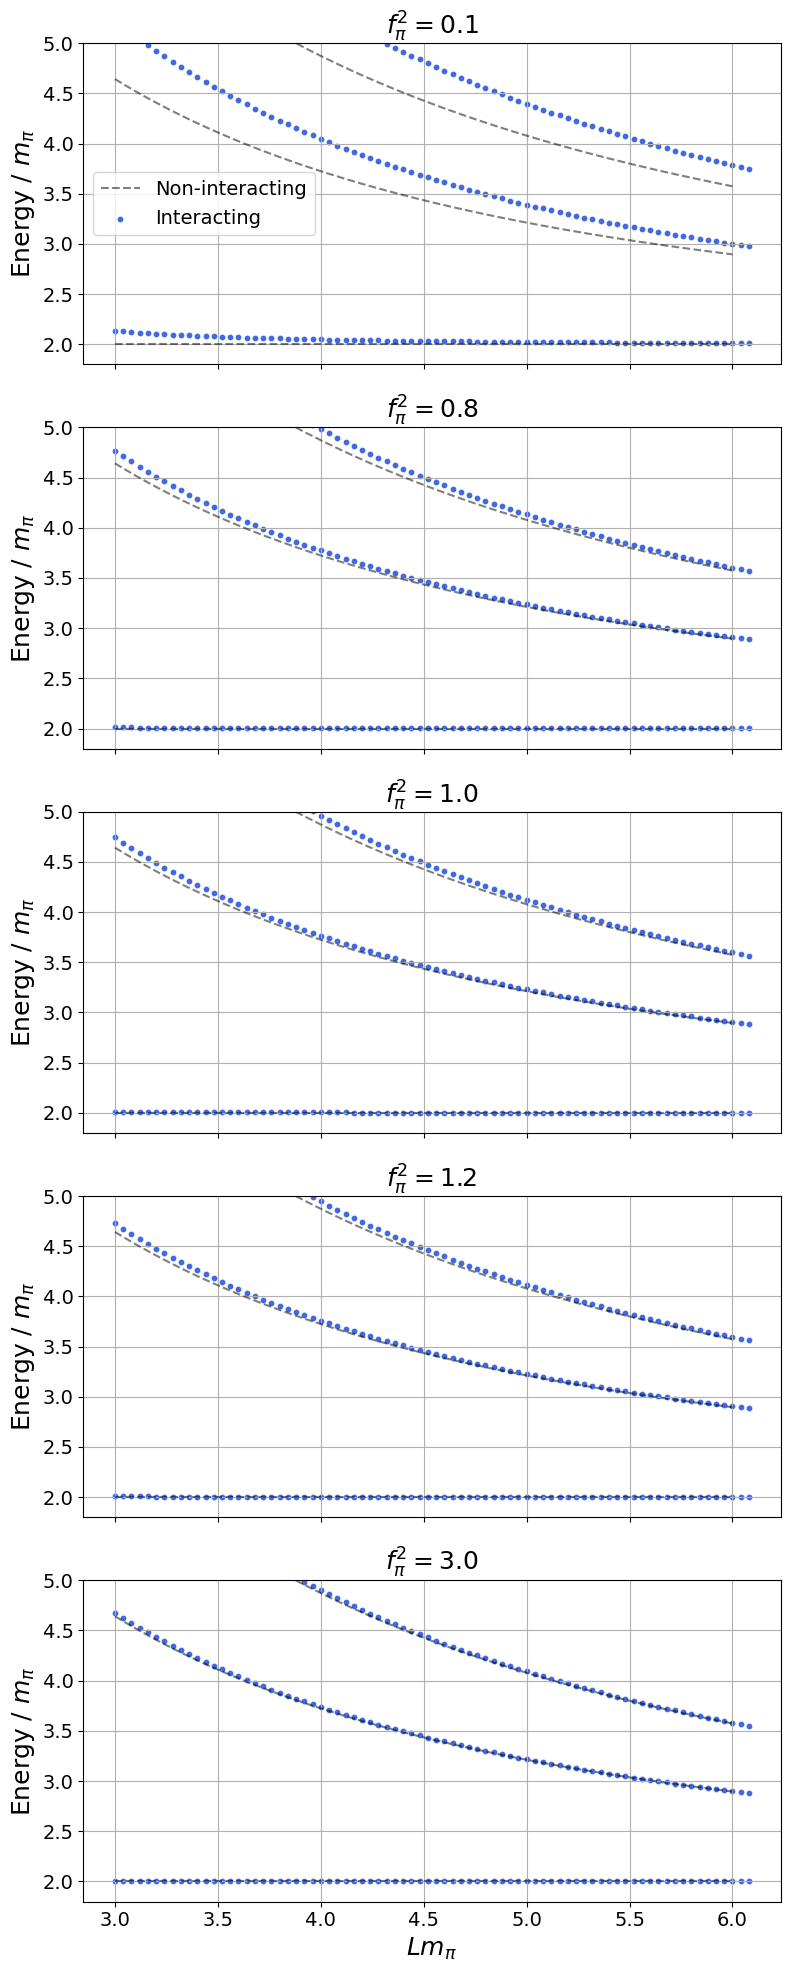

In [16]:
L_values = np.arange(3.0, 6.1, 0.04)
mSQ = 1.0
fSQ_list = [0.1, 0.8, 1.0, 1.2, 3.0]

ncols = 1
nrows = len(fSQ_list)
fig, axes = plt.subplots(nrows, ncols, figsize=(8, 4 * nrows), sharex=True)

for idx, fSQ in enumerate(fSQ_list):
    ax = axes[idx]
    Lvalues = []
    Evalues = []

    for L in L_values:
        roots = []
        for qSQ in np.arange(-0.5, 3.0, 0.01):
            try:
                res = root_scalar(qc, args=(L, mSQ, fSQ, 3, 1.0), bracket=[qSQ, qSQ + 0.1])
                if res.converged:
                    if np.abs(qc(res.root, L, mSQ, fSQ, 3, 1.0)) < 1e-6:
                        if not any(np.isclose(res.root, roots, atol=1e-9)):
                            roots.append(res.root)
            except ValueError:
                pass

        for root in roots:
            pSQ = root * (2. * np.pi / L) ** 2
            s = 4. * (pSQ + mSQ)
            Evalues.append(np.sqrt(s))
            Lvalues.append(L)

    pion_mass = np.sqrt(mSQ)
    dimensionless_L = np.array(Lvalues) * pion_mass
    dimensionless_E = np.array(Evalues) / pion_mass

    ax.scatter(dimensionless_L, dimensionless_E, s=10, color='royalblue', label="Interacting")
    
    # Non-interacting lines
    L_set = np.linspace(3, 6, 400)
    for nSQ in range(3):
        E_vals_nonint = 2 * np.sqrt(nSQ * (2. * np.pi / L_set) ** 2 + mSQ)
        ax.plot(L_set, E_vals_nonint, 'k--', alpha=0.5, label="Non-interacting" if nSQ == 0 else "")

    ax.set_ylim(1.8, 5)
    ax.set_ylabel(r"Energy / $m_\pi$")
    ax.set_title(fr"$f_\pi^2 = {fSQ}$")
    ax.grid(True)
    if idx == len(fSQ_list) - 1:
        ax.set_xlabel(r"$L m_\pi$")
    if idx == 0:
        ax.legend()

plt.tight_layout()
plt.show()
